## COPIO Y CARGO TODO COMO EN EL TP3 


In [9]:
import os
import torch
import torchaudio
import tarfile
import wandb
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [10]:
random_seed = 42

torch.manual_seed(random_seed)

# Definir parámetros
samplerate = 22050
data_dir = './genres_5sec'

init_batch_size = 20
init_num_epochs = 10
init_lr = 0.0005

In [11]:
# Función para parsear géneros
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts

# Definir la clase del dataset
class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files = []
        for c in os.listdir(root):
            self.files += [os.path.join(root, c, fname) for fname in os.listdir(os.path.join(root, c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]
        genre = parse_genres(fpath)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        return audio, class_idx

In [12]:
import torch
import torchaudio
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit

# Function to normalize the audio data across the dataset
def normalize_audio_data(dataset):
    """
    Normalize the dataset by calculating the mean and standard deviation
    of all audio samples and then applying standardization.
    """
    all_data = []
    for i in range(len(dataset)):
        audio, _ = dataset[i]
        all_data.append(audio)
    stacked_data = torch.cat(all_data, dim=1)  # Concatenate along the time dimension for mean/std calculation
    mean = stacked_data.mean()
    std = stacked_data.std()

    # Apply normalization to each sample
    normalized_data = []
    for i in range(len(dataset)):
        audio, label = dataset[i]
        normalized_audio = (audio - mean) / std
        normalized_data.append((normalized_audio, label))

    return normalized_data

# Function to create stratified train, validation, and test DataLoaders
def create_dataloaders(dataset, batch_size, test_size=0.3, val_size=0.5, random_state=42):
    """
    Normalizes the dataset, splits it into train, validation, and test subsets,
    and returns corresponding DataLoaders.
    """
    # Normalize the dataset
    normalized_data = normalize_audio_data(dataset)

    # Extract labels for stratified splitting
    labels = [label for _, label in normalized_data]

    # Stratified split: train and temporary (val+test) split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_idx, temp_idx in split.split(range(len(normalized_data)), labels):
        train_dataset = Subset(normalized_data, train_idx)
        temp_dataset = Subset(normalized_data, temp_idx)

    # Stratified split on temp data: validation and test split
    val_test_labels = [labels[i] for i in temp_idx]
    split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    for val_idx, test_idx in split.split(temp_idx, val_test_labels):
        val_dataset = Subset(normalized_data, [temp_idx[i] for i in val_idx])
        test_dataset = Subset(normalized_data, [temp_idx[i] for i in test_idx])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader, val_loader, test_loader

# Usage example with MusicDataset
dataset = MusicDataset(data_dir)
batch_size = 20
train_loader, val_loader, test_loader = create_dataloaders(dataset, batch_size)


In [13]:
list_files=os.listdir(data_dir)

classes = []

for file in list_files:

  name='{}/{}'.format(data_dir,file)

  if os.path.isdir(name):

    classes.append(file)

In [14]:
def audio_to_spectrogram(waveform):
    # Ensure the waveform is in the correct shape
    if len(waveform.shape) == 1:
        waveform = waveform.unsqueeze(0)
    
    # Convert the waveform to a spectrogram
    spectrogram = tt.Spectrogram()(waveform)
    return spectrogram

def process_dataloader_to_spectrograms(dataloader):
    spectrograms = []
    
    for batch in dataloader:
        # Assuming the batch is a tuple (waveforms, labels) and waveforms are the audio data
        waveforms, labels = batch
        
        # Process each waveform in the batch
        batch_spectrograms = [audio_to_spectrogram(waveform) for waveform in waveforms]
        
        # Append to the list of spectrograms
        spectrograms.append((torch.stack(batch_spectrograms), labels))
    
    return spectrograms

In [15]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
train_spectogram = process_dataloader_to_spectrograms(train_loader)
val_spectogram = process_dataloader_to_spectrograms(val_loader)
test_spectogram = process_dataloader_to_spectrograms(test_loader)

## CREO ENCODER CON LOS HIPERPARAMETROS DEL TP3

In [72]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=64, regularization_type=None, drop_prob=0.5):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),  # [batch, 16, 101, 276]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [batch, 32, 51, 138]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [batch, 64, 26, 69]
            nn.ReLU()
        )

        # Proyección al espacio latente
        self.latent = nn.Sequential(
            nn.Linear(64 * 26 * 69, 256),
            nn.ReLU(),
            nn.Dropout(p=drop_prob) if regularization_type == "dropout" else nn.Identity(),
            nn.Linear(256, latent_dim)
        )

        # Proyección desde el espacio latente
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=drop_prob) if regularization_type == "dropout" else nn.Identity(),
            nn.Linear(256, 64 * 26 * 69),
            nn.ReLU()
        )

        # Decoder convolucional
        self.decoder_conv = nn.Sequential(
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # Ajusta ancho
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # Ajusta ancho
    nn.ReLU(),
    nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),  # Corrige ancho final
    nn.Sigmoid()
)


    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.latent(x)

        # Decoder
        x = self.decoder(x)
        x = x.view(x.size(0), 64, 26, 69)  # Reshape para las capas convolucionales
        x = self.decoder_conv(x)
        return x


In [40]:

# Función para extraer todos los espectrogramas y convertirlos a tensores con el canal añadido
def prepare_spectrograms(loader):
    """
    Extrae los espectrogramas de un DataLoader, los convierte a un único tensor y añade el canal de color.
    Args:
        loader: DataLoader que contiene los espectrogramas y etiquetas.
    Returns:
        Tensor con forma [total_samples, 1, height, width].
    """
    spectrograms = []

    # Itera por todos los batches en el DataLoader
    for batch in loader:
        batch_spectrograms = batch[0]  # Extrae el tensor de la lista
        spectrograms.append(batch_spectrograms)
    
    # Une todos los batches en un solo tensor
    spectrograms = torch.cat(spectrograms, dim=0)  # Concatena a lo largo del eje batch
    spectrograms = spectrograms.unsqueeze(1)  # Añade el canal para escala de grises
    return spectrograms

# Prepara los datos de entrenamiento, validación y prueba
train_spectrogram = prepare_spectrograms(train_loader)
val_spectrogram = prepare_spectrograms(val_loader)
test_spectrogram = prepare_spectrograms(test_loader)

print(f"Train shape: {train_spectrogram.shape}")
print(f"Validation shape: {val_spectrogram.shape}")
print(f"Test shape: {test_spectrogram.shape}")

Train shape: torch.Size([100, 1, 1, 201, 552])
Validation shape: torch.Size([148, 1, 1, 110250])
Test shape: torch.Size([20, 1, 1, 201, 552])


## TRAINING

In [70]:
def train_autoencoder(model, dataloader, optimizer, criterion, device, epochs=20):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in dataloader:
            # No hay etiquetas; el batch contiene directamente los inputs
            inputs = batch[0].to(device) if isinstance(batch, list) or isinstance(batch, tuple) else batch.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")


## TESTING

In [75]:
def evaluate_autoencoder(model, dataloader, device):
    model.to(device)
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for data in dataloader:
            # Maneja el caso en que data es una lista o tupla
            inputs = data[0].to(device) if isinstance(data, (list, tuple)) else data.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}")


ejecutarlo todo

In [73]:
# Entrada simulada
dummy_input = torch.randn(8, 1, 201, 552)  # Batch de tamaño 8
model = Autoencoder(input_channels=1, latent_dim=64)
dummy_output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {dummy_output.shape}")

Input shape: torch.Size([8, 1, 201, 552])
Output shape: torch.Size([8, 1, 201, 552])


In [76]:
from torch.utils.data import DataLoader, TensorDataset

# Dataset simulado (reemplaza con tu dataset real)
train_data = torch.randn(100, 1, 201, 552)  # 100 espectrogramas
test_data = torch.randn(20, 1, 201, 552)   # 20 espectrogramas

train_loader = DataLoader(TensorDataset(train_data), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=8, shuffle=False)

# Modelo
model = Autoencoder(input_channels=1, latent_dim=64, regularization_type="dropout", drop_prob=0.5)

# Optimizador y criterio
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenamiento
train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=20)

# Evaluación
evaluate_autoencoder(model, test_loader, device)


Epoch [1/20], Loss: 1.2303
Epoch [2/20], Loss: 1.0686
Epoch [3/20], Loss: 1.0006
Epoch [4/20], Loss: 0.9992
Epoch [5/20], Loss: 0.9994
Epoch [6/20], Loss: 0.9993
Epoch [7/20], Loss: 0.9993
Epoch [8/20], Loss: 0.9992
Epoch [9/20], Loss: 0.9993
Epoch [10/20], Loss: 0.9994
Epoch [11/20], Loss: 0.9994
Epoch [12/20], Loss: 0.9994
Epoch [13/20], Loss: 0.9993
Epoch [14/20], Loss: 0.9993
Epoch [15/20], Loss: 0.9993
Epoch [16/20], Loss: 0.9994
Epoch [17/20], Loss: 0.9993
Epoch [18/20], Loss: 0.9994
Epoch [19/20], Loss: 0.9993
Epoch [20/20], Loss: 0.9993
Test Loss: 0.9992


## FINAL AUDIO

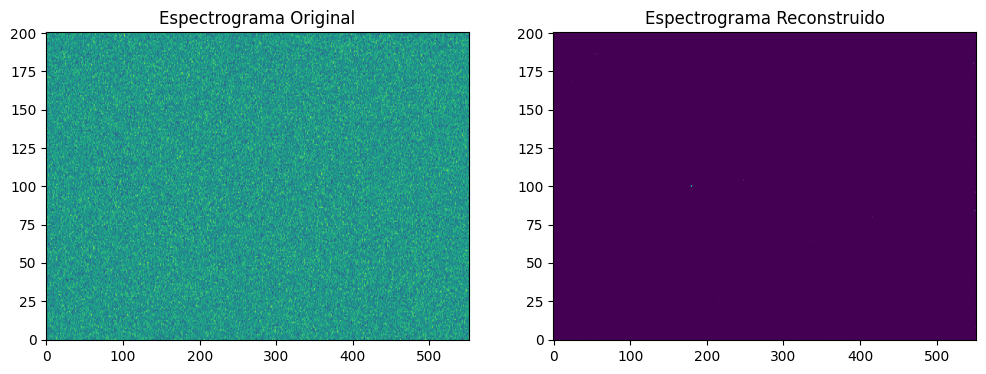

Audio Reconstruido 1:


Audio Original 1:


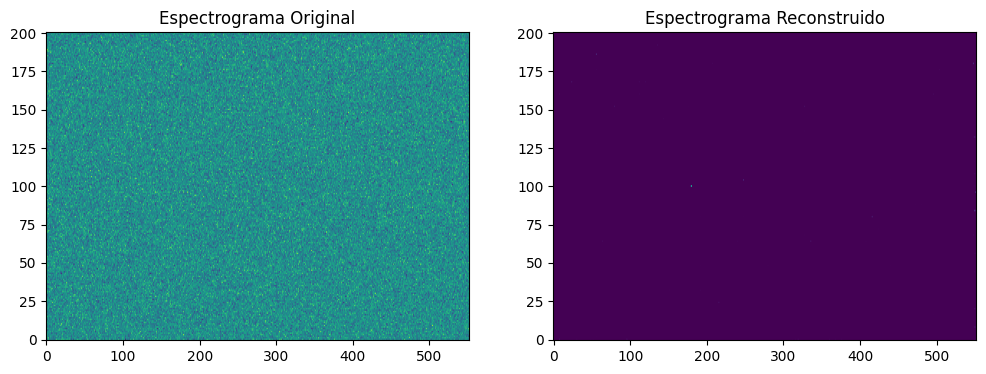

Audio Reconstruido 2:


Audio Original 2:


In [83]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
from scipy.ndimage import zoom

# Función para ajustar el espectrograma a las dimensiones esperadas
def adjust_spectrogram_shape(spectrogram, target_height):
    current_height = spectrogram.shape[0]
    zoom_factor = target_height / current_height
    return zoom(spectrogram, (zoom_factor, 1), order=1)

# Función para calcular el espectrograma
def compute_spectrogram(audio, n_fft=2048, hop_length=None, window='hann'):
    hop_length = hop_length or n_fft // 4
    window_fn = scipy.signal.get_window(window, n_fft, fftbins=True)
    stft = scipy.signal.stft(audio, window=window_fn, nperseg=n_fft, noverlap=n_fft-hop_length, return_onesided=True)[2]
    return np.abs(stft)

# Función para reconstruir audio desde espectrograma
def griffin_lim(magnitude_spectrogram, sr=22050, n_fft=2048, hop_length=None, n_iter=32):
    """
    Reconstruye una señal de audio a partir de un espectrograma de magnitud usando Griffin-Lim.
    """
    hop_length = hop_length or n_fft // 4
    target_height = n_fft // 2 + 1  # Altura esperada
    magnitude_spectrogram = adjust_spectrogram_shape(magnitude_spectrogram, target_height)

    # Inicializa la fase aleatoria
    angles = np.exp(2j * np.pi * np.random.rand(*magnitude_spectrogram.shape))
    complex_spectrogram = magnitude_spectrogram * angles

    for _ in range(n_iter):
        _, time_signal = scipy.signal.istft(complex_spectrogram, nperseg=n_fft, noverlap=n_fft-hop_length)
        _, _, new_spectrogram = scipy.signal.stft(time_signal, nperseg=n_fft, noverlap=n_fft-hop_length)
        # Actualiza la fase
        angles = np.exp(1j * np.angle(new_spectrogram))
        complex_spectrogram = magnitude_spectrogram * angles

    _, audio = scipy.signal.istft(complex_spectrogram, nperseg=n_fft, noverlap=n_fft-hop_length)
    return audio


# Función para desnormalizar espectrograma
def denormalize_spectrogram(spectrogram, min_val=0, max_val=1):
    return spectrogram * (max_val - min_val) + min_val

# Parámetros
n_fft = 2048
hop_length = 512
min_val, max_val = 0, 1
sr = 22050

# Simular entrada
model.eval()
with torch.no_grad():
    data = next(iter(test_loader))[0].to(device)
    reconstructed = model(data).cpu()

# Visualización y audio
for i in range(2):  # Muestra 2 ejemplos
    original_spec = data[i][0].cpu().numpy()
    reconstructed_spec = reconstructed[i][0].numpy()

    # Desnormalizar espectrogramas
    original_spec = denormalize_spectrogram(original_spec, min_val, max_val)
    reconstructed_spec = denormalize_spectrogram(reconstructed_spec, min_val, max_val)

    # Reconstruir audio desde espectrograma
    original_audio = griffin_lim(original_spec, sr=sr, n_fft=n_fft, hop_length=hop_length)
    reconstructed_audio = griffin_lim(reconstructed_spec, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Mostrar espectrogramas
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Espectrograma Original")
    plt.imshow(original_spec, cmap="viridis", aspect="auto", origin="lower")

    plt.subplot(1, 2, 2)
    plt.title("Espectrograma Reconstruido")
    plt.imshow(reconstructed_spec, cmap="viridis", aspect="auto", origin="lower")
    plt.show()

    # Guardar el audio reconstruido como un archivo
    sf.write(f"reconstructed_audio_{i}.wav", reconstructed_audio, samplerate=sr)

    # Reproducir los audios
    print(f"Audio Reconstruido {i+1}:")
    display(Audio(reconstructed_audio, rate=sr))

    print(f"Audio Original {i+1}:")
    display(Audio(original_audio, rate=sr))
